# Midterm Assignment, topic 7: Consumer choice model

The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Modeling consumer choice

In this assignment you consider a classic consumer choice setup given by
the utility function and budget constraint, and numerically derive the
demand function.

Reference: [Hal Varian “Microeconomic analysis”, 3 ed. 1992, Chapter 7, 8](https://books.google.com.au/books/about/Microeconomic_Analysis.html?id=m20iQAAACAAJ&redir_esc=y)

### Task 1. Design and implement a Python class to represent the model

- Use constant elasticity of substitution (CES) utility function to
  represent preferences over two goods  


$$
u(x,y) = \Big( a_1 x^{\frac{s-1}{s}} + a_2 y^{\frac{s-1}{s}} \Big)^{\frac{s}{s-1}}
$$

- Allow prices of the goods be $ p_1 $ and $ p_2 $, and budget
  constraint $ B = x p_1 + y p_2 $.  
- Design the attributes of the class and implement *init* and *repr*
  methods. Implement other methods according to your design.  
- Write a solver for the constraint consumer choice problem as a maximization
  problem in one variable, assuming that no money are wasted.  Use the
  Newton method from week 6 assignment.  Implement all the necessary
  derivative functions as methods of the class.  


Make sure that the derivatives and second derivatives are
working correctly by writing a test that compares numerical derivatives to the analytical ones.
Use the code below written to check a derivative of an arbitrary function,
and write similar code for all other derivatives.

In [22]:
import numpy as np

class consumer_choice():

    def __init__(self, p1, p2, budget, a1=0.5, a2=0.5, s=0.5):
        '''Consumer choice model using CES utility.'''
        self.a1=a1
        self.a2=a2
        self.s=(s-1)/s
        self.p1=p1
        self.p2=p2
        self.budget=budget

    def __repr__(self):
        '''String representation of the object'''
        return "option[a1="+ str(self.a1) +",a2=" + str(self.a2) +",s=" + str(self.s) +"]"

    def ufun(self, x, y):
        '''CES utility function'''
        self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)
        return self.uxy
    
    def foc(self,x):
        '''First order condition for utility maximization'''
        #monotonic transform
        self.uxy1=lambda x,y:self.al*x**self.s/self.s+self.a2*y**self.s/self.s 
        #first order condition for utility maximization
        foc=self.a1*x**(self.s-1)-(self.p1/self.p2)*self.a2*((self.budget-x*self.p1)/self.p2)**(self.s-1)
        return foc
    
    def dfoc(self,x):
        '''Derivative of the first order condition for utility maximization'''
        dfoc=self.a1*(self.s-1)*x**(self.s-2)+((self.p1/self.p2)**2)*(self.s-2)*self.a2*((self.budget-x*self.p1)/self.p2)**(self.s-2)
        return dfoc
    
    def solve(self, tol=1e-12, maxiter=100, callback=None):
        '''Newton method to solve for maximum utility
           Callback function arguments (iter,x,x1,err)
        '''
        x0=1
        for i in range(maxiter):
            x1=x0-self.foc(x0)/self.dfoc(x0)
            err=abs(x0-x1)
            if callback!=None:callback(x0=x0, x1=x1, err=err,iter=i)
            if err<tol:break
            x0=x1
        else:
            raise RuntimeError('Failed to converge in %d iterations' % maxiter)
        y1=(self.budget-self.p1*x1)/self.p2
        return x1,y1
            

It is always worth checking the code of the derivative when using Newton method.
Modify the test below to check the derivative of the optimality condition.

In [23]:
import unittest
from scipy import optimize

func = lambda x: x**5 + 10
grad = lambda x: 5*x**4

class testsDerivatives(unittest.TestCase):
    """Tests for the bisection function"""
#def test_derivative(self):
#'''test for derivative grad() of function func() over interval (1e-4,100)'''
#grid = np.linspace(1,100,11)
#for x in grid:
#self.assertTrue(optimize.check_grad(func,grad,np.array([x])) < 1e-5)
# Write your code here       

    def setvalue(self):
        #set the value p1,p2,budget,a1,a2,s of the test
        self.p1=10
        self.p2=5
        self.budget=10000
        self.a1=0.5
        self.a2=0.5
        self.s=-1
    def setfuncandgrad(self):
        #set the func and grad of the test
        self.func=lambda x:self.a1*x**(self.s-1)-(self.p1/self.p2)*self.a2*((self.budget-x*self.p1)/self.p2)**(self.s-1)
        self.grad=lambda x:self.a1*(self.s-1)*x**(self.s-2)+((self.p1/self.p2)**2)*(self.s-2)*self.a2*((self.budget-x*self.p1)/self.p2)**(self.s-2)
    def test(self):
        self.setvalue()
        self.setfuncandgrad()
        grid=np.linspace(1,100,11)
        for x in grid:
            self.assertTrue(optimize.check_grad(self.func,self.grad,np.array([x])) < 1e-5)
#run the tests
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.017s

OK


### Task 2. Write a simple function to make contour plots

It should make plots on the $ q_1 $ - $ q_2 $ plane. Use the starter code below

In [24]:
import matplotlib.pyplot as plt

def contour_plot(fun,xlim=(0,100),ylim=(0,100),ngrid=500,levels=20,title=None):
    '''Function to plot level curves of the supplied fun function of two variables'''
    # create grids for x and y
    xx=np.linspace(xlim[0],xlim[1],ngrid)
    yy=np.linspace(ylim[0],ylim[1],ngrid)
    # combine one-dimensional grids into mesh (two-dimensional grid)
    X,Y = np.meshgrid(xx,yy)
    # compute the function
    Z=fun(X,Y)
    # create levels if asked for number (otherwise pass through)
    # make plot using contour()
    if isinstance(levels, int):
        levels = np.linspace(Z.min(),Z.max(),levels)
        plt.contour(X, Y, Z, levels=levels)
        if title:
            plt.title(title)
    else:
        for i in range(len(levels)):
            if isinstance(levels[i],int):
                levelsn=np.linspace(Z.min(),Z.max(),levels[i])
                plt.contour(X,Y,Z,levels=levelsn)
                if title:
                    plt.title(title)

Test: you should see a nice picture

<ipython-input-24-2d563b380017>:23: UserWarning: No contour levels were found within the data range.
  plt.contour(X,Y,Z,levels=levelsn)


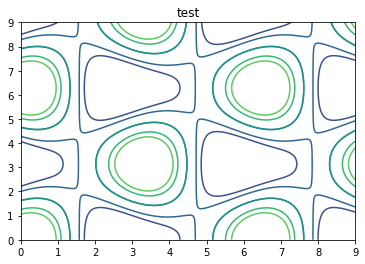

In [25]:
F = lambda x, y: 2.575 - 2*np.cos(x)*np.cos(y+np.pi) - 0.575*np.cos(1.25*np.pi - 2*x)
contour_plot(F, xlim=(0,9), ylim=(0,9), title='test', levels=[1,2,3,4,5])

### Task 3. Add plotting functionality to the model

Make the following plotting functions for the class. To make it possible to overlay different
plots, make sure that plotting methods just add plotted lines to the existing axes, and do not
use plt.show() inside any of the functions.

- Make a *plot_preferences* function which would take the model class as input and
  make a graph to illustrate the preferences. Call the contour_plot() function written
  in Task 2.  
- Make a *plot_budget* function for the class to illustrate the budget of
  the consumer as a single line in the product space.  
- Finally, make *plot_solution* function to illustrate the optimal choice
  with a budget line and the touching indifference curve.  Mark their intersection point
  with a red dot.  

<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.5,a2=0.5,s=-1.0]


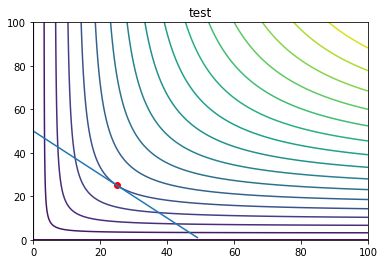

In [26]:
# write your code here
def plot_preferences(consumer_choice,p1,p2,budget,a1,a2,s,title='test'):
    model=consumer_choice(p1,p2,budget,a1,a2,s)
    func=model.ufun(0,0)
    contour_plot(func,xlim=(0,100),ylim=(0,100),title=title,levels=17)
    print(model)
    
def plot_budget(consumer_choice,p1,p2,budget,a1,a2,s):
    model=consumer_choice(p1,p2,budget,a1,a2,s)
    y=lambda x:(model.budget-model.p1*x)/model.p2
    X=np.arange(int(model.budget/model.p1))
    Y=y(X)
    plt.plot(X,Y)
    
def plot_solution(consumer_choice,p1,p2,budget,a1,a2,s):
    model=consumer_choice(p1,p2,budget,a1,a2,s)
    plot_preferences(consumer_choice,p1,p2,budget,a1,a2,s)
    plot_budget(consumer_choice,p1,p2,budget,a1,a2,s)
    x,y=model.solve()
    x=round(x)
    y=round(y)
    plt.scatter(x,y,color='r')
plot_solution(consumer_choice,2,2,100,0.5,0.5,0.5) 

### Task 4. Simple analysis

By drawing several diagrams using your code, illustrate how optimal consumer choice changes with the parameters.

For each of the sets of parameters listed in the table below

- Make a visualization of the utility function  
- Make a diagram of the solution  
- Give economic intuition for the observed differences.  


|Set|$ p_1 $|$ p_2 $|$ B $|$ a_1 $|$ a_2 $|$ s $|
|:--:|:-----------:|:-----------:|:---------:|:-----------:|:-----------:|:---------:|
|A|1.0|1.0|10.0|0.9|0.1|0.5|
|B|1.0|1.0|10.0|0.9|0.1|0.05|
|C|1.0|1.0|10.0|0.9|0.1|1.2|
|D|1.0|3.0|10.0|0.9|0.1|0.5|
|E|1.0|3.0|20.0|0.9|0.1|0.5|

<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


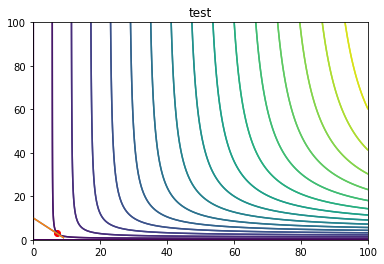

7.499999999999757 2.5000000000002434


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in power
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-18.999999999999996]


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in power
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-18.999999999999996]


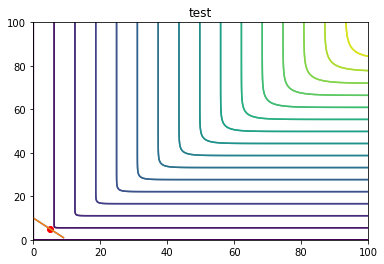

5.2743771616387845 4.7256228383612155
option[a1=0.9,a2=0.1,s=0.16666666666666663]
option[a1=0.9,a2=0.1,s=0.16666666666666663]


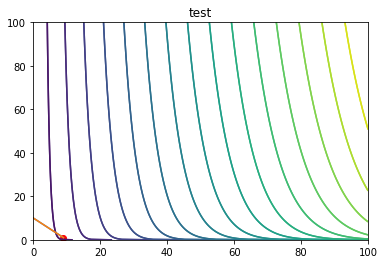

9.331846029955615 0.6681539700443846


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


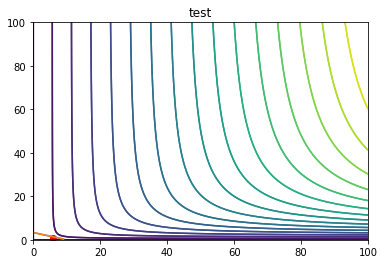

6.339745962155515 1.220084679281495


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


<ipython-input-22-49e0e6ee487a>:20: RuntimeWarning: divide by zero encountered in reciprocal
  self.uxy=lambda x,y:(self.a1*x**self.s+self.a2*y**self.s)**(1/self.s)


option[a1=0.9,a2=0.1,s=-1.0]


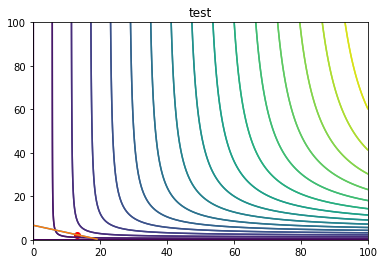

12.679491924311105 2.440169358562965


In [31]:
#set A
plot_preferences(consumer_choice,1,1,10,0.9,0.1,0.5,title='set A')
plot_budget(consumer_choice,1,1,10,0.9,0.1,0.5)
plot_solution(consumer_choice,1,1,10,0.9,0.1,0.5)
plt.show()
model=consumer_choice(1,1,10,0.9,0.1,0.5)
xa,ya=model.solve()
print(xa,ya)
#set B
plot_preferences(consumer_choice,1,1,10,0.9,0.1,0.05,title='set B')
plot_budget(consumer_choice,1,1,10,0.9,0.1,0.05)
plot_solution(consumer_choice,1,1,10,0.9,0.1,0.05)
plt.show()
model=consumer_choice(1,1,10,0.9,0.1,0.05)
xb,yb=model.solve()
print(xb,yb)
#set C
plot_preferences(consumer_choice,1,1,10,0.9,0.1,1.2,title='set C')
plot_budget(consumer_choice,1,1,10,0.9,0.1,1.2)
plot_solution(consumer_choice,1,1,10,0.9,0.1,1.2)
plt.show()
model=consumer_choice(1,1,10,0.9,0.1,1.2)
xc,yc=model.solve()
print(xc,yc)
#set D
plot_preferences(consumer_choice,1,3,10,0.9,0.1,0.5,title='set D')
plot_budget(consumer_choice,1,3,10,0.9,0.1,0.5)
plot_solution(consumer_choice,1,3,10,0.9,0.1,0.5)
plt.show()
model=consumer_choice(1,3,10,0.9,0.1,0.5)
xd,yd=model.solve()
print(xd,yd)
#set E
plot_preferences(consumer_choice,1,3,20,0.9,0.1,0.5,title='set E')
plot_budget(consumer_choice,1,3,20,0.9,0.1,0.5)
plot_solution(consumer_choice,1,3,20,0.9,0.1,0.5)
plt.show()
model=consumer_choice(1,3,20,0.9,0.1,0.5)
xe,ye=model.solve()
print(xe,ye)

### Task 5. Plotting demand

Code up a function which takes a model object as input argument, and creates a series of lines to illustrate
how optimal consumer choice changes with changing prices to give rise to demand curve.

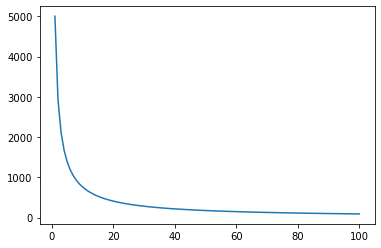

In [28]:
# write your code here
def plotdemand(consumer_choice):
    #for product p1
    p1=np.linspace(1,100,100)
    x=[]
    for i in p1:
        model=consumer_choice(i,1,10000,0.5,0.5,0.5)
        xs,ys=model.solve()
        x.append(xs)
    plt.plot(p1,x)
    plt.show()
    
plotdemand(consumer_choice)

### Task 6. Income effect

Repeat the same exercise for changing budget to illustrate the income effect in consumer choice.

- Decide and argue to either modify the already written function or
  creating a new one.  

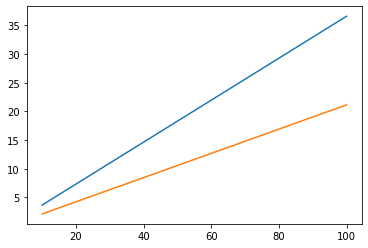

In [36]:
# write your code here
def plotincome(consumer_choice):
    #for product p1
    B=np.linspace(10,100,91)
    x=[]
    y=[]
    for i in B:
        model=consumer_choice(1,3,i,0.5,0.5,0.5)
        xs,ys=model.solve()
        x.append(xs)
        y.append(ys)
    plt.plot(B,x)
    plt.plot(B,y)
    plt.show()
    
plotincome(consumer_choice)